In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:04<00:00, 253MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [2]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [3]:
caption_dataset_path = path+'/captions.txt'
image_dataset_path =path+'/Images'

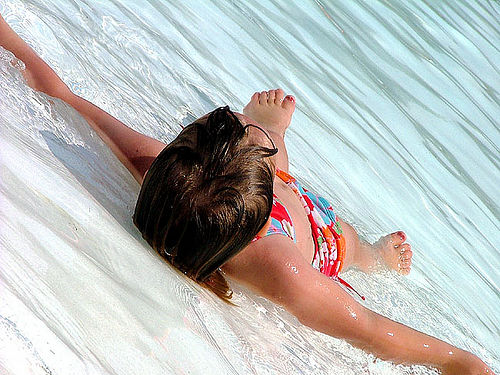

In [4]:
from IPython.display import Image
Image(path+'/Images/667626_18933d713e.jpg')

Configuring TPU

In [5]:
import tensorflow as tf

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  


REPLICAS:  8


Caption Processor

In [6]:
# load the caption file & read it
def load_caption_file(path):

    # dictionary to store captions
    captions_dict = {}

    # iterate through the file
    for caption in open(path):

        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)

        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text

    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

Preprocess the captions

In [7]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [8]:
# delete unwanted
del captions_dict

In [9]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"image,caption" : startseq  endseq


In [10]:
len(new_captions_dict)

8092

Make a list of only those images who has caption

In [11]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [12]:
caption_images_list[0]

'3157744152_31ace8c9ed'

In [13]:
len(caption_images_list)

8091

Make training, validation and test data

In [14]:
train_validate_images = caption_images_list[0:8081]

In [15]:
test_images = caption_images_list[8081:8091]
test_images

['3482314155_bd1e668b4e',
 '254475194_3d8f4dfd53',
 '3587009091_37188fd07e',
 '2595713720_30534e8de2',
 '3506468593_7e41a6d9f1',
 '3688005475_d200165cf7',
 '3666324102_18ecdf8253',
 '3353950389_1153d5e452',
 '3556598205_86c180769d',
 '1244485675_822e6efe60']

Image Feature Extractor

In [16]:
def extract_features(directory, image_keys):
    # load the model
    model = InceptionV3()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 299*299
        image = load_img(filename, target_size=(299, 299))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the inceptionV3 model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)


    return features

In [17]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

96112376/96112376 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [18]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

3157744152_31ace8c9ed : [[0.2283888  0.2432658  7.9635925  ... 0.12949032 1.8592335  2.5108056 ]]


In [19]:
len(train_validate_features)

8081

In [20]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [21]:
from pickle import load
train_validate_features = load(open('./train_validate_features.pkl', 'rb'))

Preparing the input data

In [29]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, GRU, Embedding, RepeatVector, TimeDistributed, Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Add, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [23]:
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [24]:
list(train_validate_image_caption.values())[2]

'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq'

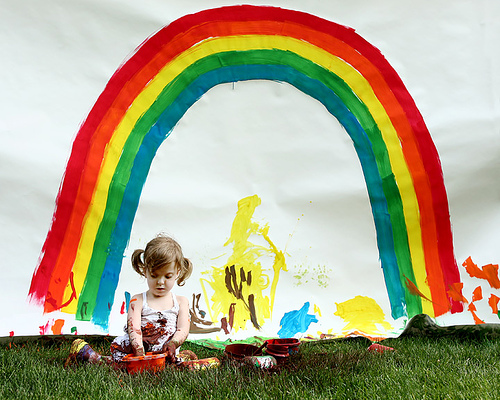

In [25]:
from IPython.display import Image
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[2]+'.jpg')

In [26]:
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

print("vocab_len ", vocab_len)
print("max_len ", max_len)

def prepare_data(image_keys):

    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)

    return np.array(x1), np.array(x2), np.array(y)

vocab_len  4465
max_len  30


In [27]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [28]:
len(train_x1)

71210

Final Model

In [30]:
embedding_size = 300
gru_units = 256

with strategy.scope():

    # feature extractor model
    image_input = Input(shape=(2048,))
    image_model_1 = Dense(embedding_size, activation='relu')(image_input)
    image_model = RepeatVector(max_len)(image_model_1)

    # sequence model
    caption_input = Input(shape=(max_len,))
    caption_model_1 = Embedding(vocab_len, embedding_size, mask_zero=True)(caption_input)
    caption_model_2 = GRU(gru_units, return_sequences=True)(caption_model_1)
    caption_model = TimeDistributed(Dense(embedding_size))(caption_model_2)

    # decoder model
    merged = Add()([image_model, caption_model])
    decoder1 = Bidirectional(GRU(gru_units, return_sequences=False))(merged)

    outputs = Dense(vocab_len, activation='softmax')(decoder1)

    # tie it together [image, seq] [word]
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 300)              1339500   ['input_3[0][0]']             
                                                                                                  
 dense (Dense)               (None, 300)                  614700    ['input_2[0][0]']             
                                                                                            

In [31]:
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Reducing Overfitting

In [32]:
filepath = './new_model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [ ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss', mode='min') ]

In [33]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (71210, 2048)
shape of train_x2  (71210, 30)
shape of train_y  (71210, 4465)

shape of validate_x1  (10302, 2048)
shape of validate_x2  (10302, 30)
shape of validate_y  (10302, 4465)


Train the model using training data and validation data¶


Training Model - Part 1

In [34]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Define training epochs
EPOCHS = 20

history = model.fit([train_x1, train_x2],
                    train_y,
                    verbose = 1,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
557/557 [==============================] - ETA: 0s - loss: 5.7703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


557/557 [==============================] - 43s 49ms/step - loss: 5.7703 - val_loss: 5.5087
Epoch 2/20
557/557 [==============================] - 14s 25ms/step - loss: 5.1934 - val_loss: 5.0177
Epoch 3/20
557/557 [==============================] - 14s 25ms/step - loss: 4.7190 - val_loss: 4.7974
Epoch 4/20
557/557 [==============================] - 14s 25ms/step - loss: 4.4177 - val_loss: 4.6885
Epoch 5/20
557/557 [==============================] - 14s 25ms/step - loss: 4.2097 - val_loss: 4.6275
Epoch 6/20
557/557 [==============================] - 14s 25ms/step - loss: 4.0408 - val_loss: 4.6332
Epoch 7/20
557/557 [==============================] - 14s 25ms/step - loss: 3.8983 - val_loss: 4.5715
Epoch 8/20
557/557 [==============================] - 14s 25ms/step - loss: 3.7662 - val_loss: 4.5755
Epoch 9/20
557/557 [==============================] - 14s 25ms/step - loss: 3.6479 - val_loss: 4.6007
Epoch 10/20
557/557 [==============================] - 14s 25ms/step - loss: 3.5339 - val_los

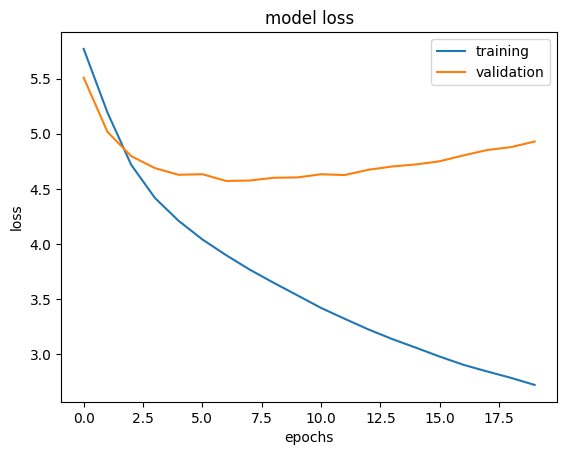

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [36]:
model.save('./fork_latest_model.h5')

Evaluate the mode

In [37]:
def extract_feat(filename):
    # load the model
    model = InceptionV3()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [38]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [40]:
modl = load_model('./new_model-ep01-loss5.770-val_loss5.509.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+test_images[count]))

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq swings in in in in endseq

Actual caption ->  startseq bull is charging man in an arena endseq
*********************************************************************

Predicted caption ->  startseq swings is in in in endseq

Actual caption ->  startseq black dog runs in grassy yard while woman dressed in green watches from in fton of tan house endseq
*********************************************************************

Predicted caption ->  startseq boy is in in endseq

Actual caption ->  startseq dog is swimming through deep water near several ducks endseq
*********************************************************************

Predicted caption ->  startseq boy is in in endseq

Actual caption ->  startseq girl in cowboy hat with sheep on leash endseq
*********************************************************************

Predicted caption ->  startseq swings is in in in endseq

Actual caption ->  startseq girl swings on vine over water endseq
*************

In [42]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu

# Load the pre-trained model
modl = load_model('./new_model-ep01-loss5.770-val_loss5.509.h5')

# Prepare the tokenizer
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

# Generate descriptions and evaluate with BLEU score
for count in range(10):
    # Extract features from the image
    photo = extract_feat('{}.jpg'.format(image_dataset_path + '/' + test_images[count]))

    # Generate the caption
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()

    # Retrieve the actual caption
    actual_caption = new_captions_dict[test_images[count]]
    print("Actual caption -> ", actual_caption)
    print()

    # Calculate BLEU score
    reference = [actual_caption.split()]  # BLEU expects a list of references (each reference is a list of words)
    candidate = description.split()       # The candidate is also a list of words
    bleu_score = sentence_bleu(reference, candidate)
    print("BLEU Score -> ", bleu_score)
    print('*********************************************************************')
    print()

Predicted caption ->  startseq swings in in in in endseq

Actual caption ->  startseq bull is charging man in an arena endseq

BLEU Score ->  1.1077199809555581e-231
*********************************************************************



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Predicted caption ->  startseq swings is in in in endseq

Actual caption ->  startseq black dog runs in grassy yard while woman dressed in green watches from in fton of tan house endseq

BLEU Score ->  2.614745472486257e-232
*********************************************************************

Predicted caption ->  startseq boy is in in endseq

Actual caption ->  startseq dog is swimming through deep water near several ducks endseq

BLEU Score ->  6.657922819542466e-232
*********************************************************************

Predicted caption ->  startseq boy is in in endseq

Actual caption ->  startseq girl in cowboy hat with sheep on leash endseq

BLEU Score ->  7.865406450922293e-232
*********************************************************************

Predicted caption ->  startseq swings is in in in endseq

Actual caption ->  startseq girl swings on vine over water endseq

BLEU Score ->  1.2778269941762074e-231
*****************************************************